In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec

### Kernels

In [2]:
# Blur Filter
a = np.zeros([3, 3, 3, 3])
a[1, 1, :, :] = 0.25
a[0, 1, :, :] = 0.125
a[1, 0, :, :] = 0.125
a[2, 1, :, :] = 0.125
a[1, 2, :, :] = 0.125
a[0, 0, :, :] = 0.0625
a[0, 2, :, :] = 0.0625
a[2, 0, :, :] = 0.0625
a[2, 2, :, :] = 0.0625

BLUR_FILTER_RGB = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 1.0
a[0, 1, :, :] = 1.0
a[1, 0, :, :] = 1.0
a[2, 1, :, :] = 1.0
a[1, 2, :, :] = 1.0
a[0, 0, :, :] = 1.0
a[0, 2, :, :] = 1.0
a[2, 0, :, :] = 1.0
a[2, 2, :, :] = 1.0

BLUR_FILTER = tf.constant(a, dtype=tf.float32)

In [4]:
# Sharpen filter
a = np.zeros([3, 3, 3, 3])
a[1, 1, :, :] = 5
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[2, 1, :, :] = -1
a[1, 2, :, :] = -1

SHARPEN_FILTER_RGB = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[1, 1, :, :] = 5
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[2, 1, :, :] = -1
a[1, 2, :, :] = -1

SHARPEN_FILTER = tf.constant(a, dtype=tf.float32)

In [7]:
# Edge filter
a = np.array([[[[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]],
              [[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]],
              [[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]]],
             [[[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]],
              [[ 8., 0., 0.], [ 0., 8., 0.], [ 0., 0., 8.]],
              [[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]]],
             [[[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]],
              [[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]],
              [[ -1., 0., 0.], [ 0., -1., 0.], [ 0., 0., -1.]]]])

EDGE_FILTER_RGB = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, 1, :, :] = -1
a[1, 0, :, :] = -1
a[1, 2, :, :] = -1
a[2, 1, :, :] = -1
a[1, 1, :, :] = 4

EDGE_FILTER = tf.constant(a, dtype=tf.float32)

In [8]:
# Sobel filter
a = np.zeros([3, 3, 3, 3])
a[0, :, :, :] = 1
a[0, 1, :, :] = 2 
a[2, :, :, :] = -1
a[2, 1, :, :] = -2

TOP_SOBEL_RGB = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, :, :, :] = 1
a[0, 1, :, :] = 2 
a[2, :, :, :] = -1
a[2, 1, :, :] = -2

TOP_SOBEL = tf.constant(a, dtype=tf.float32)

In [9]:
# Emboss filter
a = np.zeros([3, 3, 3, 3])
a[0, 0, :, :] = -2
a[0, 1, :, :] = -1 
a[1, 0, :, :] = -1
a[1, 1, :, :] = 1
a[1, 2, :, :] = 1
a[2, 1, :, :] = 1
a[2, 2, :, :] = 2

EMBOSS_FILTER_RGB = tf.constant(a, dtype=tf.float32)

a = np.zeros([3, 3, 1, 1])
a[0, 0, :, :] = -2
a[0, 1, :, :] = -1 
a[1, 0, :, :] = -1
a[1, 1, :, :] = 1
a[1, 2, :, :] = 1
a[2, 1, :, :] = 1
a[2, 2, :, :] = 2
EMBOSS_FILTER = tf.constant(a, dtype=tf.float32)

### Image Utility Functions

In [72]:
def read_one_image(filename):
    """
    Reads image from a file into a tensor. Output 
    is a tensor object.
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_image(image_string)
    image = tf.cast(image_decoded, tf.float32) / 256.0
    return image

# def convolve(image, kernels, rgb=True, strides=[1, 3, 3, 1], padding='SAME'):
#     images = [image[0]]
#     for i, kernel in enumerate(kernels):
#         filtered_image = tf.nn.conv2d(images, kernel, strides=strides, 
#                                       padding=padding)[0]
#         if i == 2:
#             filtered_image = tf.minimum(tf.nn.relu(filtered_image), 255)
#         images.append(filtered_image)
#     return images

def convolve(image, kernels, rgb=True, strides=[1, 1, 1, 1], padding='SAME'):
    images = []
    for i, kernel in enumerate(kernels):
        filtered_image = tf.nn.conv2d(image, kernel, strides=strides, 
                                      padding=padding)[0]
        if i == 2:
            filtered_image = tf.minimum(tf.nn.relu(filtered_image), 255)
        images.append(filtered_image)
    return images

def show_images(images, rgb=True):
    gs = gridspec.GridSpec(1, len(images))
    for i, image in enumerate(images):
        plt.subplot(gs[0, i])
        if rgb:
            plt.imshow(image)
        else:
            image = image.reshape(image.shape[0], image.shape[1])
            plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()
    
def plot(filename, rgb=True):
    if rgb:
        kernels = [BLUR_FILTER_RGB, SHARPEN_FILTER_RGB, EDGE_FILTER_RGB,
                   TOP_SOBEL_RGB, EMBOSS_FILTER_RGB]
    else:
        kernels = [BLUR_FILTER, SHARPEN_FILTER, EDGE_FILTER, TOP_SOBEL,
                   EMBOSS_FILTER]
        
    image = read_one_image(filename)
    
    if not rgb:
        image = tf.image.rgb_to_grayscale(image)
        
    image = tf.expand_dims(image, 0)  # Make it into a batch of 1 element
    images = convolve(image, kernels, rgb=rgb)
    
    with tf.Session() as sess:
        images = sess.run(images)
    
    show_images(images, rgb=rgb)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


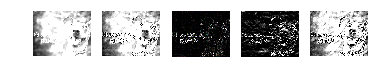

In [73]:
plot('./data/friday.jpg')

### Scratch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


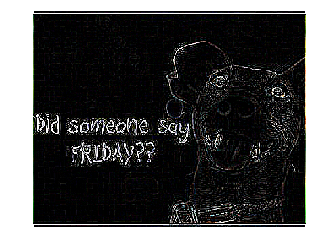

In [80]:
img = read_one_image('./data/friday.jpg')
img = tf.expand_dims(img, 0)
f_img = tf.nn.conv2d(img, EDGE_FILTER_RGB, strides=[1, 1, 1, 1], padding='SAME')

with tf.Session() as sess:
    out_img = sess.run(f_img)
    
show_images([out_img[0]])